# Code for fitting Astro RC data

In [1]:
#!/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind')
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15)

import pandas as pd
import pystan
import corner

import pickle
import os
import sys
import glob

from omnitool.literature_values import Av_coeffs, hawkvals
from omnitool import scalings
from omnitool.literature_values import Rsol


__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
def read_data():
    '''Reads in the Yu et al. 2018 data'''
    sfile = __datdir__+'rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

def read_paramdict(majorlabel, minorlabel='', sort='astero'):
    '''Reads in results for either:
        -A full run series (majorlabel) where the minorlabel is included as a
            column in the output.
        -A single run (majorlabel and minorlabel).

        Returns a pandas dataframe.
    '''
    loc = __outdir__+majorlabel+'/'

    if minorlabel != '':
        globlist = glob.glob(loc+sort+'_'+str(float(minorlabel))+'_*pars*.csv')
    else:
        globlist = glob.glob(loc+sort+'*_*pars*.csv')

    minorlabels = [os.path.basename(globloc).split('_')[1] for globloc in globlist]

    df = pd.DataFrame()
    for n, globloc in enumerate(globlist):
        sdf = pd.read_csv(globloc, index_col = 0)
        if minorlabels[n] != 'pars.csv':
            sdf[majorlabel] = minorlabels[n]
        df = df.append(sdf)

    return df.sort_values(by=majorlabel)

def get_covmatrix(ccd):
    #Calculate the sigma for this sample
    Draij = np.zeros((len(ccd), len(ccd)))
    Ddij = np.zeros_like(Draij)

    #There is probably a much faster way to do this... but right now I can't think of one
    print('Finding separations, creating cov matrix...')
    for i in range(len(ccd)):
        for j in range(len(ccd)):
            Draij[i, j] = ccd.ra[j] - ccd.ra[i]
            Ddij[i, j] = ccd.dec[j] - ccd.dec[j]

    thetaij = np.sqrt(Draij**2 + Ddij**2)
    Sigmaij = 285*10**-6 * np.exp(-thetaij / 14)
    np.fill_diagonal(Sigmaij, np.diag(Sigmaij) + ccd.parallax_error**2)
    print('Done.')

    return Sigmaij

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [3]:
df = read_data()
print('Size: '+str(len(df)))
df.head(2)

Size: 5578


,KICID,kepmag_x,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,...,Ebv,Aks,Aj,Ah,H17_Ag,L,L_err,Mbol,Mbol_err,Z
0,892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,...,0.090092,0.016483,0.066545,0.033477,0.256763,72.126040,13.744428,0.10477,0.206899,0.010827
1,1026084,12.14,15,1139.0,41.17,0.90,4.414,0.061,63.8,2.9,...,0.082530,0.015099,0.060960,0.030667,0.235211,81.549973,12.518103,-0.02856,0.166663,0.013321


## Stan model for astrometric values

The model works perfectly in the K-band, so I'm going to read in the existing version, and not worry about changes. The issues are in the data.

In [4]:
model_path = 'astrostan.pkl'
sm = pickle.load(open(model_path, 'rb'))

In [5]:
verbose = False
# verbose = True
if verbose:
    print(sm)

#### Run the model

In [6]:
ccdno = 1
tempdiff = 0.0

ccd = df[df.ccd == ccdno].reset_index()[:50]
print('CCD '+str(ccdno)+': '+str(len(ccd)))

rlebv = ccd.Ebv.values * 2.740
mband = np.ones(len(ccd)) * ccd.GAIAmag.values
sel = (mband > 6.) & (mband < 16.5)
mband[sel] = 0.0505 + 0.9966*mband[sel]
merr = ccd.e_GAIAmag.values

astres = read_paramdict('pre-4chainruns/lt_GAIA_tempscale_Clump', 50.0, 'astero')

Sigma = get_covmatrix(ccd)
Sigpure = np.diag(ccd.parallax_error**2)

dat = {'N':len(ccd),
        'm': mband,
        'm_err': np.ones(len(mband))*10.e-3,
        'oo': ccd.parallax.values,
        'Sigma': Sigma,         #Covariance matrix per Lindegren+18, Zinn+18
        'RlEbv': rlebv,
        'mu_init': astres['mu'].values[0],
        'mu_spread': astres['mu_std'].values[0]}

init= {'mu': astres.mu.values[0],
        'sigma': astres.sigma.values[0],
        'Q': astres.Q.values[0],
        'sigo': astres.sigo.values[0],
        'L': 1000.,
        'oo_zp':-29.}

CCD 1: 50
Finding separations, creating cov matrix...
Done.


In [9]:
fit = sm.sampling(data=dat, iter=5000, chains=4, init=[init,init, init, init])

/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


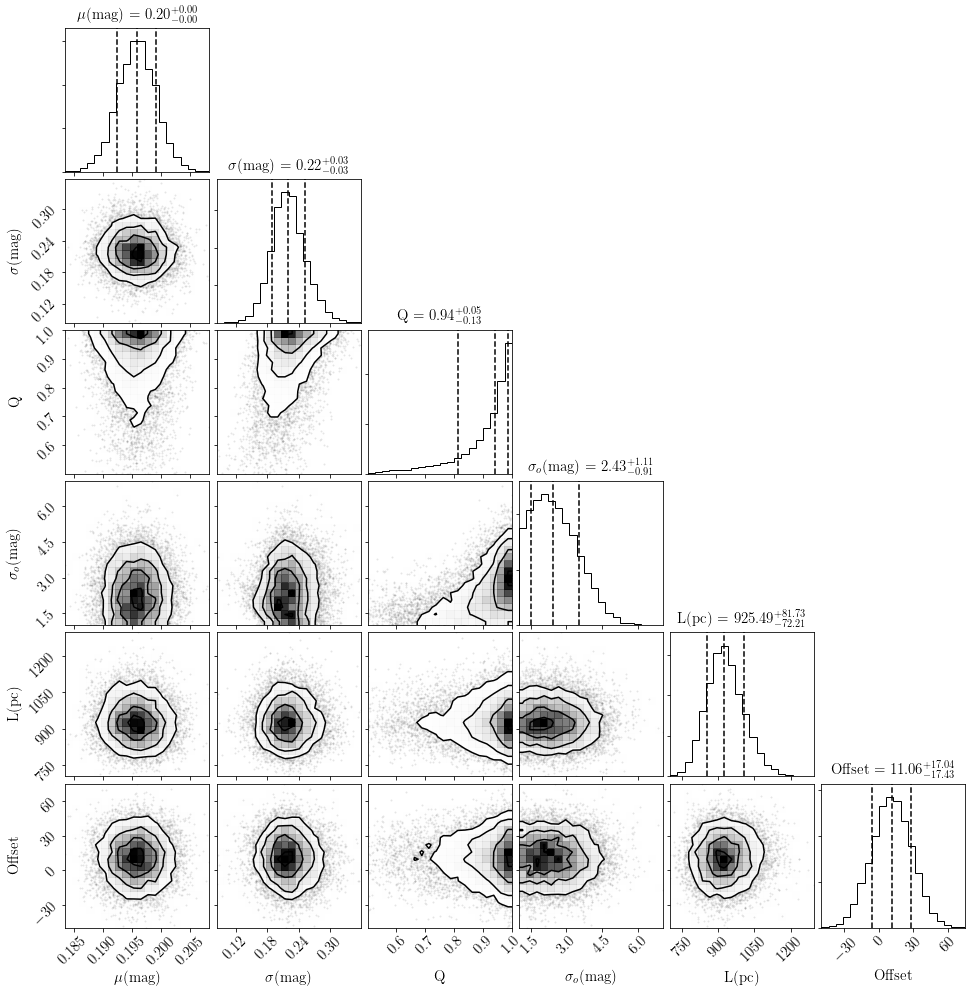

In [10]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo'],fit['L'], fit['oo_zp']])
corner.corner(chain.T,\
                labels=[r'$\mu$(mag)',r'$\sigma$(mag)','Q',r'$\sigma_o$(mag)','L(pc)', 'Offset'],\
                quantiles=[0.16, 0.5, 0.84],\
                show_titles=True, title_kwargs={"fontsize": 15})
plt.show()

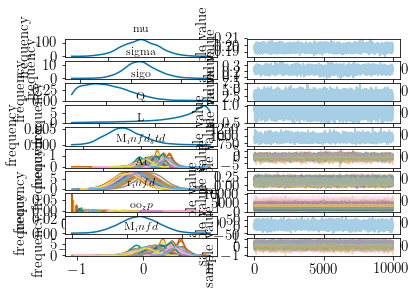

In [11]:
fit.plot()
plt.show()

In [12]:
print(fit)

Inference for Stan model: astrostan_8b60a1f6cf90af9c30b1aaad1f35b5fb.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                0.2  3.3e-5 3.3e-3   0.19   0.19    0.2    0.2    0.2  10000    1.0
sigma            0.22  7.2e-4   0.03   0.16    0.2   0.22   0.24   0.29 2121.0    1.0
sigo             2.54  9.6e-3   0.96   1.11   1.78   2.43   3.18    4.6  10000    1.0
Q                 0.9  1.8e-3    0.1   0.61   0.87   0.94   0.98    1.0 3196.0    1.0
L               930.1    0.78  77.53 792.52 876.91 925.49 979.33 1093.9  10000    1.0
M_infd_std[0]    0.92  4.5e-3   0.45   0.04   0.62    0.9    1.2   1.84  10000    1.0
M_infd_std[1]    0.46  2.8e-3   0.28  -0.07   0.28   0.45   0.63   1.02  10000    1.0
M_infd_std[2]    0.31  5.7e-3   0.57   -0.8  -0.06   0.32   0.69   1.42  10000    1.0
M_infd_std[3]    1.71  7.5e-3   0.36 

Total number of Rhats: 207
Total number of Rhats with the NaN values removed: 207
Total number of Rhats over 1.01: 0
Total number of Rhats over 1.1: 0


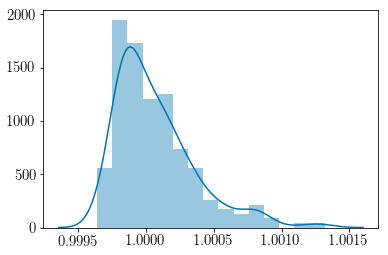

In [13]:
s = fit.summary()
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
print('Total number of Rhats over 1.01: '+str(len(rhat[rhat > 1.01])))
print('Total number of Rhats over 1.1: '+str(len(rhat[rhat > 1.1])))
sns.distplot(rhatfin)
plt.show()

### Some further diagnostic plots

In [14]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
sigo = (np.median(fit['sigo']))* sigma
Q = np.median(fit['Q'])
Minfd = np.median(fit['M_infd'],axis=0)
rinfd = np.median(fit['r_infd'],axis=0)
Linfd = np.median(fit['L'],axis=0)

x = np.linspace(Minfd.min(), Minfd.max(), 1000)
fg = normal(x, mu, sigma)
bg = normal(x, mu, sigo)
L = Q*fg + (1-Q)*bg

Text(0,0.5,u'Units arbitrary')

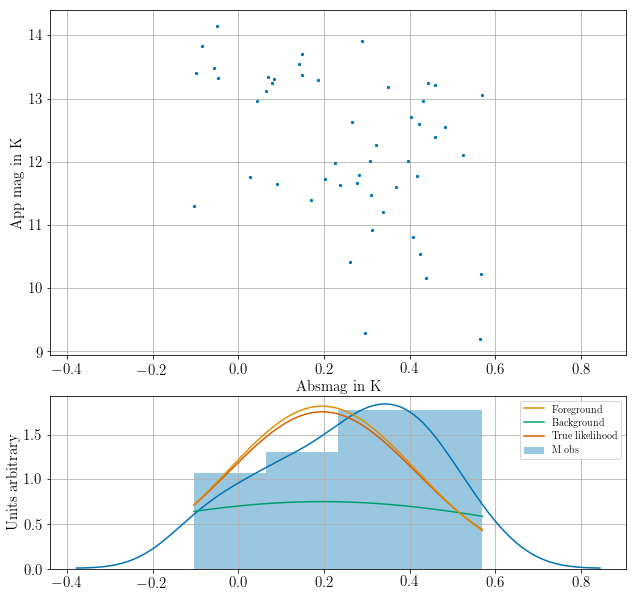

In [15]:
left, bottom, width, height = 0.1, 0.47, 1., 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3],sharex=sax)

sax.scatter(Minfd,mband,s=5,zorder=1000)

sns.distplot(Minfd, ax=xax, label='M obs')
xax.plot(x,fg,label='Foreground',zorder=999)
xax.plot(x,bg,label='Background',zorder=998)
xax.plot(x, L,label='True likelihood',zorder=997)
xax.legend()

sax.grid()
xax.grid()

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

The above plot compares the inferred absolute Kband magnitude to the observed absolute Kband magnitude--- there are more data points at the red clump overdensity which is expected, as the points will have been placed there within the constraints of the observational uncertainties. 

There appears to be some kind of offset still, as there appears to be some correlation around the bisector at the inferred absolute magnitude positions.

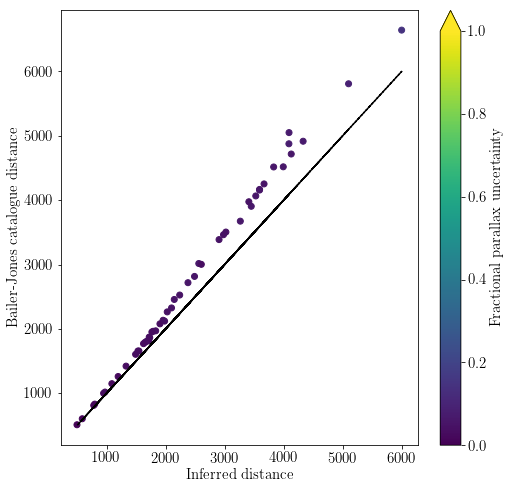

Our L: 925.491966625126
BJ+18 median L: 819.1059629772305


In [16]:
fig, ax = plt.subplots(figsize=(8,8))
f = np.abs(ccd.parallax_error/ccd.parallax)
c = plt.scatter(ccd.r_est,rinfd,c=f, vmin=0., vmax=1.)
fig.colorbar(c, label='Fractional parallax uncertainty',extend='max')
ax.plot(ccd.r_est, ccd.r_est,c='k',linestyle='-.')
ax.set_xlabel('Inferred distance')
ax.set_ylabel('Bailer-Jones catalogue distance')
plt.show()
print('Our L: '+str(Linfd))
print('BJ+18 median L: '+str(np.median(ccd.r_length_prior)))

Given that our L is smaller, we expect the mode of the prior distribution to be at a **lower distance**, and therefore we expect stars with high fractional uncertainties to be have a **lower inferred distance**. This means we would expect high fractional uncertainty stars to be *below* the bisector. That appears to be the case, although we'll need to run on more stars to confirm.

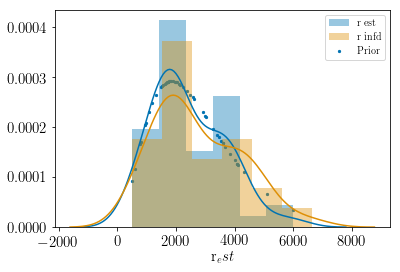

In [17]:
r = ccd.r_est
prior = (1/(2*Linfd**3)) * (r*r) * np.exp(-r/Linfd)

sns.distplot(ccd.r_est,label='r est')
sns.distplot(rinfd, label='r infd')
plt.scatter(r,prior,s=5,label='Prior')
plt.legend()
plt.show()

From this it looks like the best fit value of L does not comply well for the full dataset--- could this be because L varies as a function of galactic position?